<a href="https://colab.research.google.com/github/YulayNaumov/-ODS/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_ODS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import random
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
import sklearn as skl
import plotly.graph_objects as go
import torch
import os
import torch.nn as nn
import shutil
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import patoolib
import copy
import matplotlib
import albumentations as A
import torch.optim as optim
import cv2
try:
  import transformers # Huggingface’s transformers library
except:
  !pip install transformers
  import transformers

from albumentations.pytorch import ToTensorV2
from pandas.core.common import random_state
from google.colab import files
from sklearn.utils import resample
from sklearn.datasets import make_classification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from PIL import Image
from sklearn.metrics import confusion_matrix
from transformers import AutoModel, AutoTokenizer , BertTokenizerFast
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (25.0, 7.0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 112.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 130.0 MB/s eta 0:00:00


In [ ]:
os.makedirs("dataset", exist_ok=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
patoolib.extract_archive("/content/drive/MyDrive/xray-lung-segmentation.zip", outdir='/content/dataset')

patool: Extracting /content/drive/MyDrive/xray-lung-segmentation.zip ...
patool: running /usr/bin/7z x -o/content/dataset -- /content/drive/MyDrive/xray-lung-segmentation.zip
patool: ... /content/drive/MyDrive/xray-lung-segmentation.zip extracted to `/content/dataset'.


'/content/dataset'

In [ ]:
os.makedirs("/content/dataset/test", exist_ok=True)
os.makedirs("/content/dataset/train", exist_ok=True)

In [ ]:
patoolib.extract_archive("/content/dataset/data_test.zip", outdir='/content/dataset/test')
patoolib.extract_archive("/content/dataset/data_train.zip", outdir='/content/dataset/train')

patool: Extracting /content/dataset/data_test.zip ...
patool: running /usr/bin/7z x -o/content/dataset/test -- /content/dataset/data_test.zip
patool: ... /content/dataset/data_test.zip extracted to `/content/dataset/test'.
patool: Extracting /content/dataset/data_train.zip ...
patool: running /usr/bin/7z x -o/content/dataset/train -- /content/dataset/data_train.zip
patool: ... /content/dataset/data_train.zip extracted to `/content/dataset/train'.


'/content/dataset/train'

In [ ]:
img_dir = '/content/dataset/train/data_train'
for filename in os.listdir(img_dir):
    if '_preview' in filename:
        os.remove(os.path.join(img_dir, filename))
    if "idx.txt" in filename:
      os.remove(os.path.join(img_dir, filename))

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, img_names, transform=None):
        self.img_dir = img_dir
        self.img_names = img_names
        self.transform = transform
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        #print(img_name)
        image = cv2.imread(os.path.join(self.img_dir, img_name), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.img_dir, img_name.replace('.png', '_msk.png')), cv2.IMREAD_COLOR)[:,:,0:1]
        image = image.astype(np.float32)/255.0
        mask = mask.astype(np.float32)/255.0
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            mask = np.transpose(mask, (2,0,1))
            
            #mask = torch.from_numpy(mask)
        return image, mask

In [ ]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=232, min_width=232),
        A.RandomCrop(232, 232),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(1.0, 1.0, 1.0), std=(1.0, 1.0, 1.0)),
        ToTensorV2(),
    ]
)

In [ ]:
img_dir = '/content/dataset/train/data_train'
img_names = []
for i in os.listdir(img_dir):
  if '_msk' not in i:
    img_names.append(i)

dataset = SegmentationDataset(img_dir, img_names, train_transform)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=0)

In [ ]:
for i, data in enumerate(dataloader,0):
  None

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        mask = np.transpose(mask, (1,2,0))
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

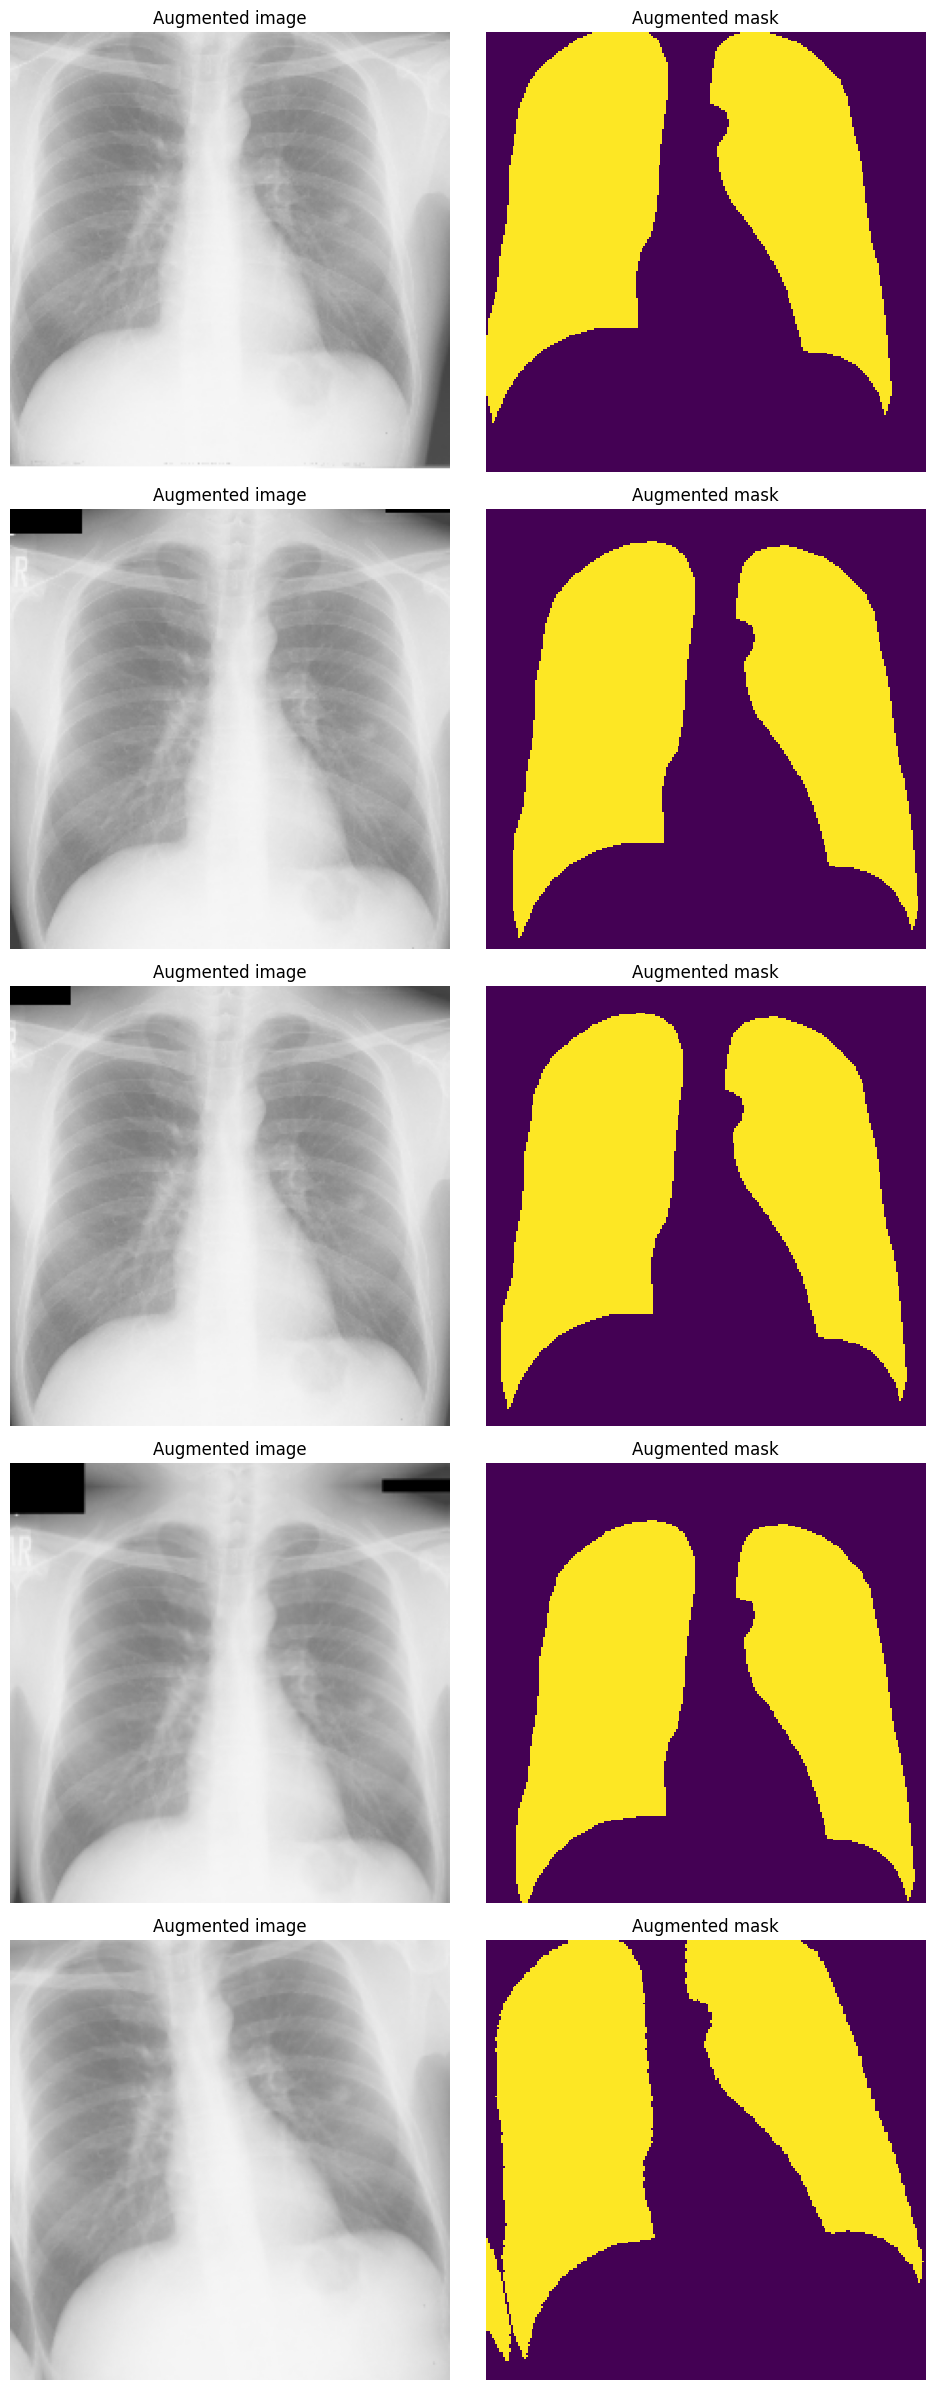

In [ ]:
visualize_augmentations(dataset, 0)

In [59]:
# Инициализация модели
class Model(nn.Module):
    def __init__(self, nc):
        super().__init__()

        self.actT = nn.Tanh()
        self.act = nn.GELU()
        self.pool = nn.MaxPool2d(2,2)

        self.gn0_1 = nn.GroupNorm(2, nc)
        self.gn0_2 = nn.GroupNorm(2, nc)
        self.gn0_3 = nn.GroupNorm(2, nc)
        self.gn0_4 = nn.GroupNorm(2, nc)

        self.gn1_1 = nn.GroupNorm(2, 2*nc)
        self.gn1_2 = nn.GroupNorm(2, 2*nc)
        self.gn1_3 = nn.GroupNorm(2, 2*nc)
        self.gn1_4 = nn.GroupNorm(2, 2*nc)

        self.gn3_1 = nn.GroupNorm(2, 2*nc)
        self.gn3_2 = nn.GroupNorm(2, 2*nc)
        self.gn3_3 = nn.GroupNorm(2, 2*nc)
        self.gn3_4 = nn.GroupNorm(2, 2*nc)

        self.gn4_1 = nn.GroupNorm(2, 2*nc)
        self.gn4_2 = nn.GroupNorm(2, 2*nc)
        self.gn4_3 = nn.GroupNorm(2, 2*nc)
        self.gn4_4 = nn.GroupNorm(2, 2*nc)       

        self.gn5_1 = nn.GroupNorm(2, 2*nc)
        self.gn5_2 = nn.GroupNorm(2, 2*nc)
        self.gn5_3 = nn.GroupNorm(2, 2*nc)
        self.gn5_4 = nn.GroupNorm(2, 2*nc)

        self.gn6_1 = nn.GroupNorm(2, 2*nc)
        self.gn6_2 = nn.GroupNorm(2, 2*nc)
        self.gn6_3 = nn.GroupNorm(2, 2*nc)
        self.gn6_4 = nn.GroupNorm(2, 2*nc)        


        self.gn2_1 = nn.GroupNorm(2, nc)
        self.gn2_2 = nn.GroupNorm(2, nc)
        self.gn2_3 = nn.GroupNorm(2, nc)
        self.gn2_4 = nn.GroupNorm(2, nc)        


        self.conv0_1 = nn.Conv2d(3, nc, 7)
        self.conv0_2 = nn.Conv2d(nc, nc, 3)
        self.conv0_3 = nn.Conv2d(nc, nc, 3)
        self.conv0_4 = nn.Conv2d(nc, nc, 3)

        self.conv1_1 = nn.Conv2d(nc, 2*nc, 3)
        self.conv1_2 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv1_3 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv1_4 = nn.Conv2d(2*nc, 2*nc, 3)


        self.conv3_1 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv3_2 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv3_3 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv3_4 = nn.Conv2d(2*nc, 2*nc, 3)

        self.conv4_1 = nn.Conv2d(4*nc, 2*nc, 3)
        self.conv4_2 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv4_3 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv4_4 = nn.Conv2d(2*nc, 2*nc, 3)  
        
        self.conv5_1 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv5_2 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv5_3 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv5_4 = nn.Conv2d(2*nc, 2*nc, 3) 

        self.conv6_1 = nn.Conv2d(4*nc, 2*nc, 3)
        self.conv6_2 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv6_3 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv6_4 = nn.Conv2d(2*nc, 2*nc, 3)         

        self.conv2_1 = nn.Conv2d(3*nc, nc, 3)
        self.conv2_2 = nn.Conv2d(nc, nc, 3)
        self.conv2_3 = nn.Conv2d(nc, nc, 3)
        self.conv2_4 = nn.Conv2d(nc, 1, 3)


    def forward(self, x):

        _,_,h0,w0 = x.shape
        ######################################## 111111111111111111111111111
        fea = self.conv0_1(x)
        fea = self.gn0_1(fea)
        fea = self.act(fea)
        fea = self.conv0_2(fea)
        fea = self.gn0_2(fea)
        fea = self.act(fea)
        fea = self.conv0_3(fea)
        fea = self.gn0_3(fea)
        fea = self.act(fea)
        fea = self.conv0_4(fea)
        fea = self.gn0_4(fea)
        fea = self.act(fea)        
        

        _,_,h,w = fea.shape
        ######################################## 22222222222222222222222222222222222
        fea_deep = self.conv1_1(fea)
        fea_deep = self.gn1_1(fea_deep)
        fea_deep = self.act(fea_deep)
        fea_deep = self.conv1_2(fea_deep)
        fea_deep = self.gn1_2(fea_deep)
        fea_deep = self.act(fea_deep)
        fea_deep = self.conv1_3(fea_deep)
        fea_deep = self.gn1_3(fea_deep)
        fea_deep = self.act(fea_deep)
        fea_deep = self.conv1_4(fea_deep)
        fea_deep = self.gn1_4(fea_deep)
        fea_deep = self.act(fea_deep)

        _,_,ha2,w2 = fea_deep.shape
        fea_deep_2 = self.pool(fea_deep)
        ###########################################     333333333333333333333333333333333333
        fea_deep_2 = self.conv3_1(fea_deep_2)
        fea_deep_2 = self.gn3_1(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)
        fea_deep_2 = self.conv3_2(fea_deep_2)
        fea_deep_2 = self.gn3_2(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)
        fea_deep_2 = self.conv3_3(fea_deep_2)
        fea_deep_2 = self.gn3_3(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)
        fea_deep_2 = self.conv3_4(fea_deep_2)
        fea_deep_2 = self.gn3_4(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)

        _,_,ha3,w3 = fea_deep_2.shape
        fea_deep_3 = self.pool(fea_deep_2)
        ###########################################     44444444444444444444444444444444444444444
        fea_deep_3 = self.conv5_1(fea_deep_3)
        fea_deep_3 = self.gn5_1(fea_deep_3)
        fea_deep_3 = self.act(fea_deep_3)
        fea_deep_3 = self.conv5_2(fea_deep_3)
        fea_deep_3 = self.gn5_2(fea_deep_3)
        fea_deep_3 = self.act(fea_deep_3)
        fea_deep_3 = self.conv5_3(fea_deep_3)
        fea_deep_3 = self.gn5_3(fea_deep_3)
        fea_deep_3 = self.act(fea_deep_3)
        fea_deep_3 = self.conv5_4(fea_deep_3)
        fea_deep_3 = self.gn5_4(fea_deep_3)
        fea_deep_3 = self.act(fea_deep_3)

        fea_deep_3 = F.upsample(fea_deep_3, size = (ha3,w3), mode = 'bilinear')
        fea_deep_2 = torch.cat((fea_deep_2, fea_deep_3), axis = 1)
        del fea_deep_3

        ###########################################     333333333333333333333333333333333333
        fea_deep_2 = self.conv6_1(fea_deep_2)
        fea_deep_2 = self.gn6_1(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)
        fea_deep_2 = self.conv6_2(fea_deep_2)
        fea_deep_2 = self.gn6_2(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)
        fea_deep_2 = self.conv6_3(fea_deep_2)
        fea_deep_2 = self.gn6_3(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)
        fea_deep_2 = self.conv6_4(fea_deep_2)
        fea_deep_2 = self.gn6_4(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)

        fea_deep_2 = F.upsample(fea_deep_2, size = (ha2,w2), mode = 'bilinear')
        fea_deep = torch.cat((fea_deep, fea_deep_2), axis = 1)
        del fea_deep_2
        #######################################      222222222222222222222222222222222222222
        fea_deep = self.conv4_1(fea_deep)
        fea_deep = self.gn4_1(fea_deep)
        fea_deep = self.act(fea_deep)
        fea_deep = self.conv4_2(fea_deep)
        fea_deep = self.gn4_2(fea_deep)
        fea_deep = self.act(fea_deep)
        fea_deep = self.conv4_3(fea_deep)
        fea_deep = self.gn4_3(fea_deep)
        fea_deep = self.act(fea_deep)
        fea_deep = self.conv4_4(fea_deep)
        fea_deep = self.gn4_4(fea_deep)
        fea_deep = self.act(fea_deep)

        fea_deep = F.upsample(fea_deep, size = (h,w), mode = 'bilinear')
        #########################################         1111111111111111111111111111111111111111111
        fea = torch.cat((fea, fea_deep), axis = 1)
        del fea_deep
        fea = self.conv2_1(fea)
        fea = self.gn2_1(fea)
        fea = self.act(fea)
        fea = self.conv2_2(fea)
        fea = self.gn2_2(fea)
        fea = self.act(fea)
        fea = self.conv2_3(fea)
        fea = self.gn2_3(fea)
        fea = self.act(fea)

        fea = self.conv2_4(fea)        

        fea = F.upsample(fea, size = (h0,w0), mode = 'bilinear')

        return fea

model = Model(20)

In [60]:
#Критерии полезны для обучения нейронной сети. Учитывая входные данные и цель, они вычисляют градиент в соответствии с заданной функцией потерь
criterion = nn.BCEWithLogitsLoss()
#torch.optim - это пакет, реализующий различные алгоритмы оптимизации. Наиболее часто используемые методы уже поддерживаются, а интерфейс достаточно общий, так что более сложные методы могут быть также легко интегрированы в будущем.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
model = model.to(device)
criterion = criterion.to(device)

In [63]:
torch.cuda.is_available()

True

In [64]:
loss_sum = []
epochs = 35
for epoch in range(epochs):  # многократное прохождение по набору данных
    avg_loss = 0
    running_loss = 0.0
    for i, data in enumerate(dataloader,0):
        # получаем входные данные; данные - это список [inputs, labels].
        img, mask = data#.values()
        img = img.to(device)
        mask = mask.to(device)

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(img)
        loss = criterion(outputs, mask)
        loss_sum.append(loss.item())
        loss.backward()
        optimizer.step()
        # вывести статистику обучения
        running_loss += loss.item() 
        if i % 25 == 0:    # вывести каждые 10 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1:.3f}')
          running_loss = 0.0

    scheduler.step()

print('Finished Training')

[1,     1] loss: 0.763
[1,    26] loss: 10.081
[1,    51] loss: 8.006
[2,     1] loss: 0.249
[2,    26] loss: 5.988
[2,    51] loss: 5.576
[3,     1] loss: 0.212
[3,    26] loss: 5.302
[3,    51] loss: 5.232
[4,     1] loss: 0.227
[4,    26] loss: 4.904
[4,    51] loss: 4.933
[5,     1] loss: 0.192
[5,    26] loss: 4.707
[5,    51] loss: 4.540
[6,     1] loss: 0.146
[6,    26] loss: 4.318
[6,    51] loss: 4.302
[7,     1] loss: 0.201
[7,    26] loss: 4.284
[7,    51] loss: 4.213
[8,     1] loss: 0.153
[8,    26] loss: 3.885
[8,    51] loss: 3.924
[9,     1] loss: 0.140
[9,    26] loss: 4.040
[9,    51] loss: 3.811
[10,     1] loss: 0.145
[10,    26] loss: 3.896
[10,    51] loss: 3.767
[11,     1] loss: 0.148
[11,    26] loss: 3.502
[11,    51] loss: 3.459
[12,     1] loss: 0.125
[12,    26] loss: 3.334
[12,    51] loss: 3.286
[13,     1] loss: 0.135
[13,    26] loss: 3.375
[13,    51] loss: 3.349
[14,     1] loss: 0.114
[14,    26] loss: 3.134
[14,    51] loss: 3.401
[15,     1] loss: 

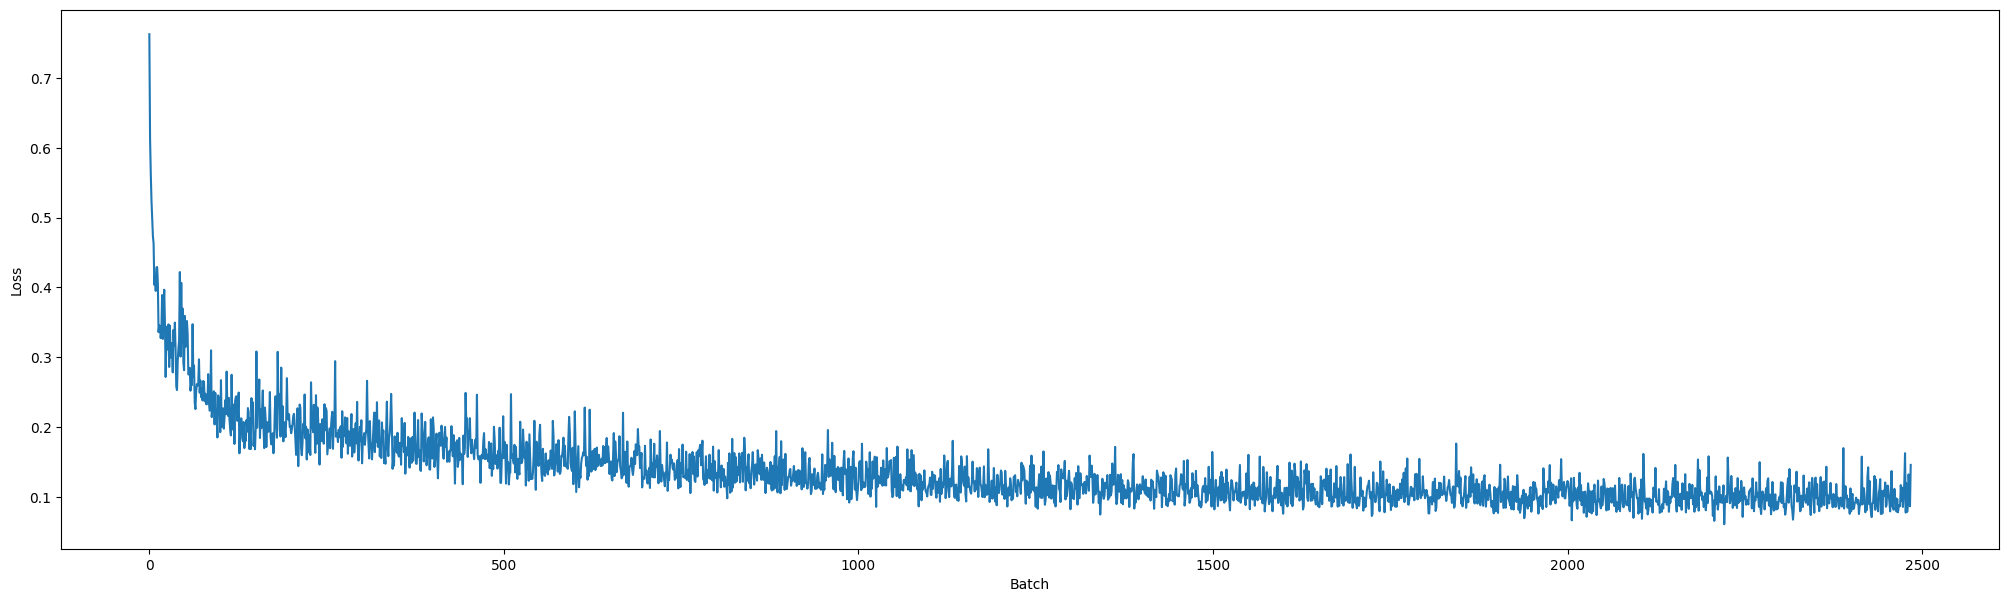

In [65]:
plt.plot(loss_sum)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

In [66]:
img = dataset[100][0].unsqueeze(0)
img = img.to(device)
pred = model(img)
print(type(pred))
pred = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1,2,0)

<class 'torch.Tensor'>


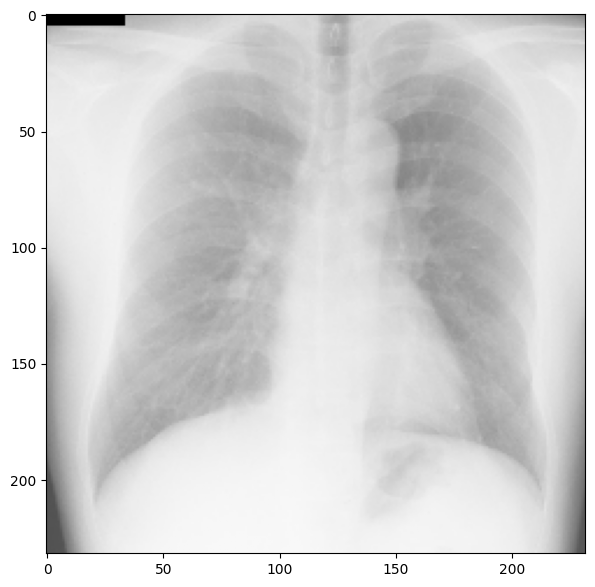

In [67]:
img_np = img.detach().cpu().numpy()[0].transpose(1,2,0)
plt.imshow(img_np)

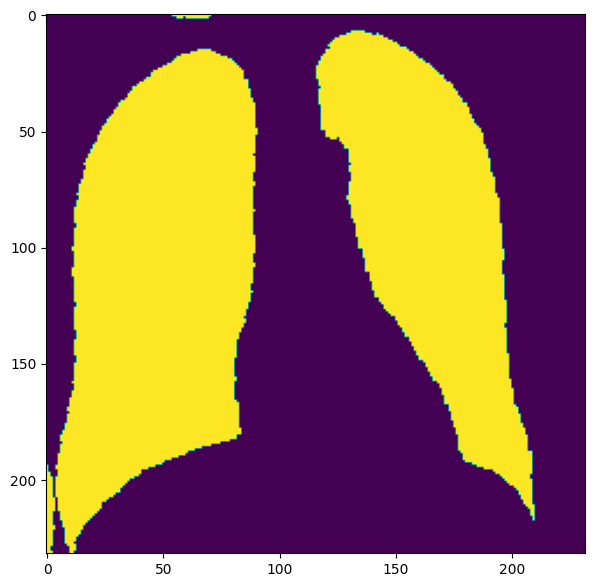

In [68]:
msk = dataset[100][1].unsqueeze(0)
msk = msk.to(device)
msk = msk.detach().cpu().numpy()[0].transpose(1,2,0)
plt.imshow(msk)

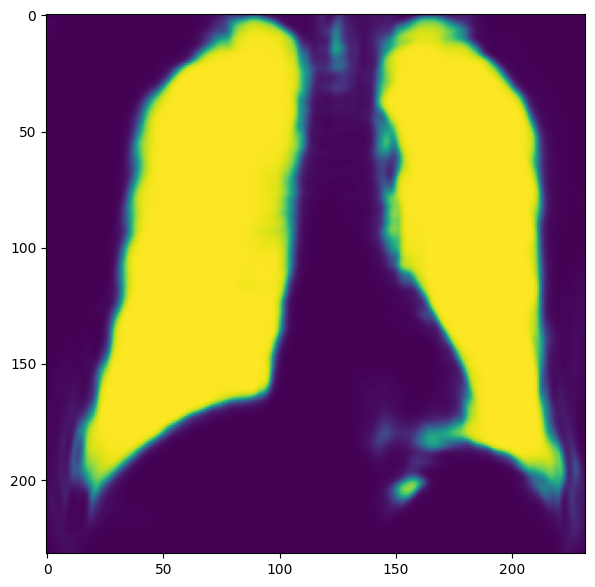

In [69]:
plt.imshow(pred)

In [70]:
class SegmentationDataset_Test(Dataset):
    def __init__(self, img_dir, img_names, transform=None):
        self.img_dir = img_dir
        self.img_names = img_names
        self.transform = transform
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        image = cv2.imread(os.path.join(self.img_dir, img_name), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32)/255.0
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
            
        return image

In [71]:
img_dir = '/content/dataset/test/data_test'
img_names = []
for i in os.listdir(img_dir):
    img_names.append(i)

dataset_test = SegmentationDataset_Test(img_dir, img_names, train_transform)

In [72]:
pred_list = []
for i in dataset_test:
  im = i.unsqueeze(0)
  im = im.to(device)
  pred = model(im)
  pred = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1,2,0)
  pred_list.append(pred)

In [75]:
def visualize_test(test, pred, samples = 15):
    dataset = copy.deepcopy(test)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image = dataset[i]
        mask = pred[i]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

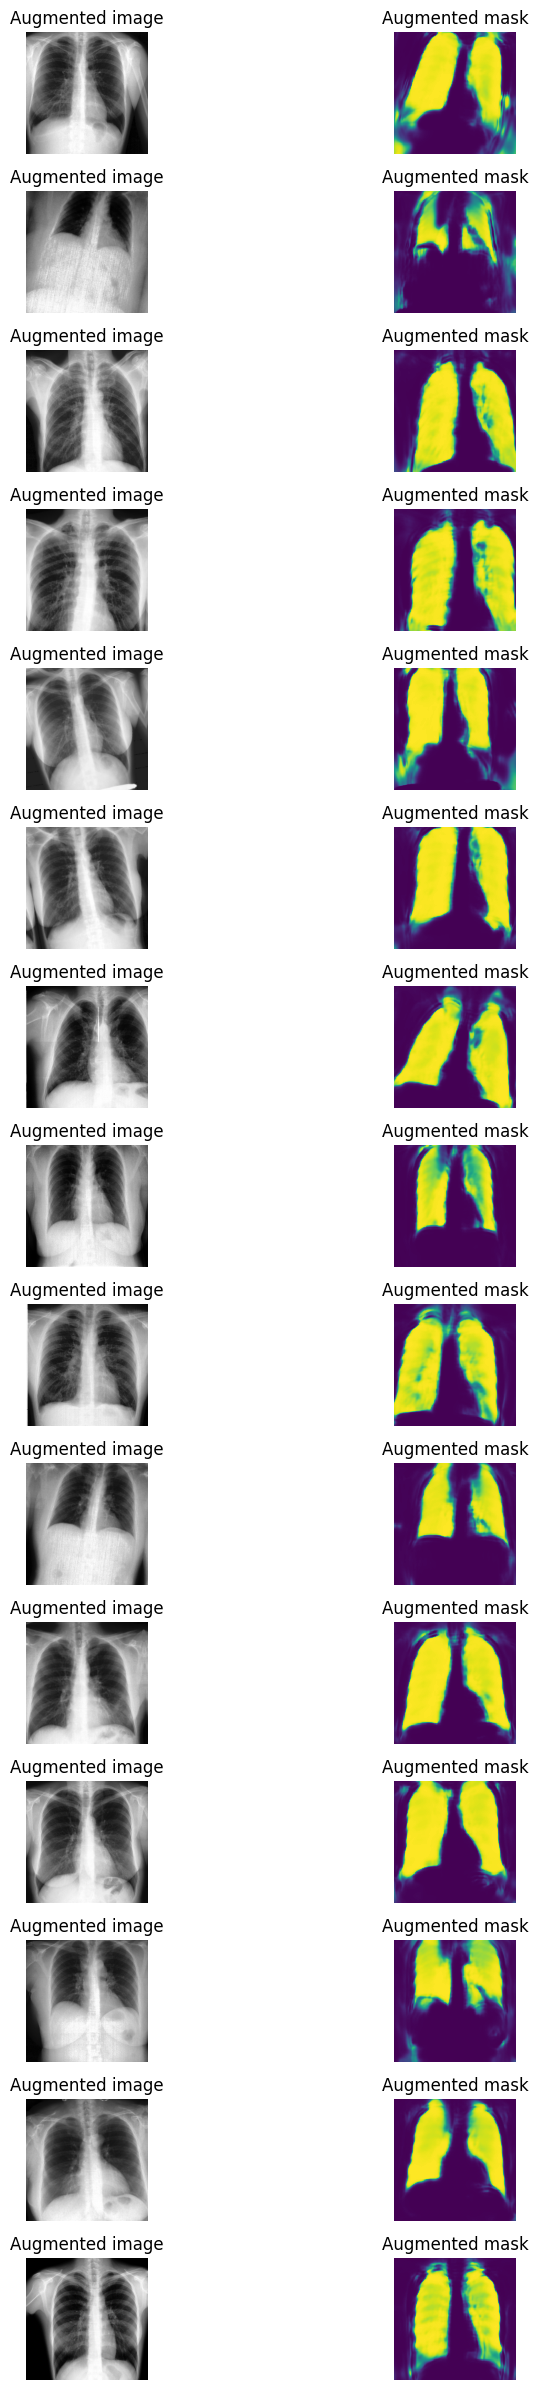

In [76]:
visualize_test(dataset_test, pred_list)